In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

2024-10-17 14:55:03.762595: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-17 14:55:07.722648: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### __1. Import and data pre-processing:__

In [2]:
# import counts dataframe:

df_counts = pd.read_csv("dataset/mdd_counts.csv") 
df_counts = df_counts.set_index("Unnamed: 0")

print(df_counts.shape)
df_counts.head()

(281, 1052)


,ENSG00000004059,ENSG00000004776,ENSG00000006015,ENSG00000006283,ENSG00000007062,ENSG00000008300,ENSG00000008323,ENSG00000008382,ENSG00000011566,ENSG00000013725,...,ENSG00000263142,ENSG00000268500,ENSG00000268598,ENSG00000269343,ENSG00000269858,ENSG00000269955,ENSG00000270326,ENSG00000270585,ENSG00000271207,ENSG00000272636
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
14.aINS,8.996242,0.103986,2.621305,1.610692,1.495194,2.045752,0.00000,2.184767,21.565145,0.049781,...,0.611700,0.0,0.529774,2.442070,0.862148,0.0,1.855580,0.000000,0.000000,5.121861
17.aINS,8.903824,0.436902,2.950058,3.044226,0.986233,2.577052,0.00000,2.858730,18.016300,0.053784,...,1.027330,0.0,0.635963,2.128504,1.152073,0.0,2.227519,0.242431,0.039514,5.773299
20.aINS,11.186563,0.365299,3.003535,2.308878,1.807888,2.433533,0.00000,2.651374,20.614090,0.095389,...,0.552249,0.0,0.676757,2.912190,1.356395,0.0,1.185201,0.085994,0.042048,4.829895
23.aINS,10.507356,0.144972,2.333444,2.918354,1.254059,2.282867,0.01465,2.406256,19.575888,0.093694,...,0.787202,0.0,0.369292,2.499131,1.252572,0.0,1.293479,0.187700,0.000000,4.259085
28.aINS,11.416718,0.305866,2.083884,1.916791,1.371925,2.001595,0.00000,1.999301,20.719654,0.087857,...,0.945770,0.0,0.173143,2.483541,1.112255,0.0,1.212900,0.176007,0.000000,6.010410


In [3]:
# import metadata:

df_meta = pd.read_csv("dataset/mdd_meta.csv")
df_meta = df_meta.set_index("!Sample_title")
df_meta.head()

,14,17,20,23,28,32,40,43,45,51,...,205,212,222,235,236,238,242,246,247,249
!Sample_title,,,,,,,,,,,,,,,,,,,,,
gender,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male,...,Female,Female,Female,Female,Female,Female,Female,Female,Male,Female
cause of death,Natural,Natural,Accident,Suicide,Natural,Suicide,Suicide,Suicide,Suicide,Suicide,...,Suicide,Natural,Suicide,Suicide,Suicide,Suicide,Natural,Suicide,Accident,Suicide
age,47,41,31,19,46,40,49,33,38,53,...,48,82,36,52,60,22,68,59,59,51
phenotype,CTRL,CTRL,CTRL,CTRL,CTRL,CTRL,MDD,CTRL,CTRL,MDD,...,MDD,CTRL,MDD,MDD,CTRL,CTRL,CTRL,MDD,CTRL,CTRL


0.0 11.84080508726906 8427.35517600903


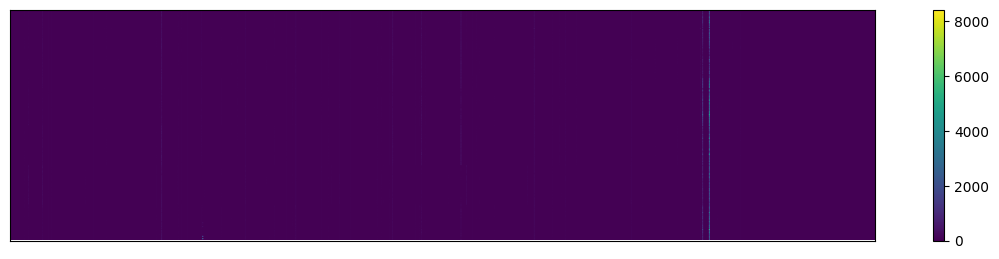

In [4]:
# select (x, y) data:
# x -> counts table
# y -> (sample, phenotype, denger)

counts = df_counts.to_numpy()
print(counts.min(), counts.mean(), counts.max())

plt.figure(figsize=(15,3))
plt.imshow(counts)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

0.0 0.1568379641609071 1.0


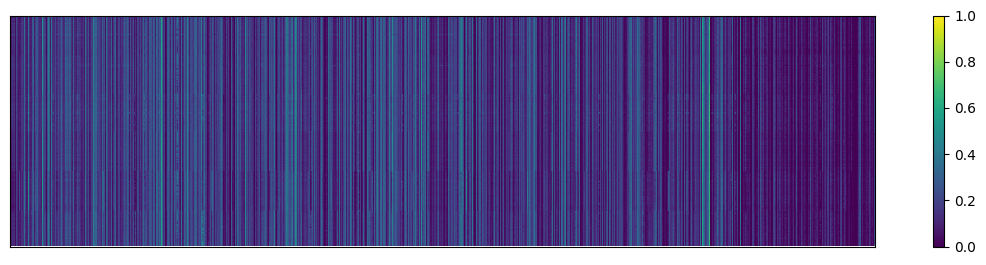

In [5]:
# normalization:
x = np.log(counts+1)
x /= x.max()

print(x.min(), x.mean(), x.max())

plt.figure(figsize=(15,3))
plt.imshow(x)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

In [6]:
# meta -> (subject_id, sample, phenotype, gender)

meta = [x.split(".") for x in df_counts.index]

N = len(meta)

for i in range(N):
    n = meta[i][0]
    
    meta[i] += df_meta.loc[['phenotype', 'gender'], n].tolist()

meta = np.array(meta)
print(meta.shape)
meta

(281, 4)


array([['14', 'aINS', 'CTRL', 'Male'],
       ['17', 'aINS', 'CTRL', 'Male'],
       ['20', 'aINS', 'CTRL', 'Male'],
       ...,
       ['246', 'Sub', 'MDD', 'Female'],
       ['247', 'Sub', 'CTRL', 'Male'],
       ['249', 'Sub', 'CTRL', 'Female']], dtype='<U6')

In [7]:
# one-hot encoding:

def one_hot(meta):

    labels = np.array(list(set(meta)))
    hot = np.zeros((len(meta), len(labels)))

    for i, x in enumerate(meta):
        j = np.where(x == labels)[0]
        hot[i][j] = 1.0

    return hot

meta1 = one_hot(meta.T[1])
meta2 = one_hot(meta.T[2])
meta3 = one_hot(meta.T[3])

y = np.concatenate([meta1, meta2, meta3], axis=1)

print("y:", y.shape)

y[:4]

y: (281, 10)


array([[0., 1., 0., 0., 0., 0., 0., 1., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0., 1., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0., 1., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0., 1., 1., 0.]])

In [8]:
# shuffling:
N_samples = x.shape[0]
i = np.random.permutation(N_samples)
x, y = x[i], y[i]
meta = meta[i]

x.shape, y.shape

((281, 1052), (281, 10))

In [9]:
# splitting (x, y) into (x, x-test):
N_test = int(0.10*N_samples)

x_test = x[:N_test]
x = x[N_test:]

print(f"x:{x.shape}, x-test:{x_test.shape}")

y_test = y[:N_test]
y = y[N_test:]

print(f"y:{y.shape}, y-test:{y_test.shape}")


x:(253, 1052), x-test:(28, 1052)
y:(253, 10), y-test:(28, 10)


In [10]:
# deleting unnecessary arrays:

del df_counts, df_meta, counts
del meta1, meta2, meta3

### __2. Neural network modeling:__

In [11]:
def MyModel():
    
    N = 1052
    In = keras.Input((N, ))
    
    x = layers.Dense(400, activation='relu')(In)
    
    x = layers.Dense(200, activation='relu')(x)
    x = layers.Dense(20, activation='relu')(x)
    x = layers.Dense(200, activation='relu')(x)
    x = layers.Dense(400, activation='relu')(x)
    
    Out = layers.Dense(N, activation='sigmoid')(x)
    
    return keras.Model(inputs=In, outputs=Out)
    
model = MyModel()
model.summary()

2024-10-17 14:55:13.728185: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1052)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 400)            │       421,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        80,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │         4,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 200)            │         4,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 400)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1052)           │       421,852 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,011,872 (3.86 MB)

 Trainable params: 1,011,872 (3.86 MB)

 Non-trainable params: 0 (0.00 B)

### __3. Model compilation:__

In [12]:
model.compile(optimizer="Adam", loss="mse", metrics=['mae'])

### __4. K-fold cross-validation:__   

### __5. Final training__    

In [ ]:
report = model.fit(x=x, y=x, epochs=20)

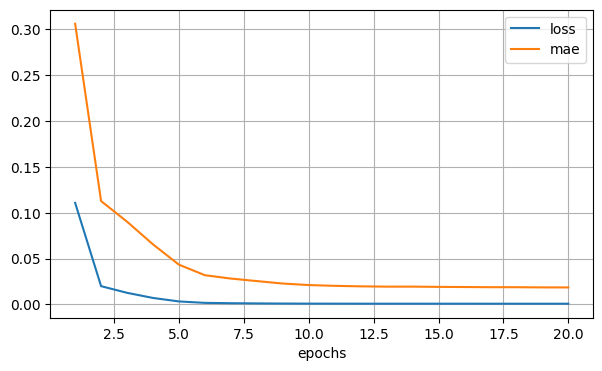

In [14]:
loss = report.history['loss']
mae = report.history['mae']
epochs = np.linspace(1, len(loss), len(loss))

plt.figure(figsize=(7, 4))

plt.plot(epochs, loss, label="loss")
plt.plot(epochs, mae, label="mae")
plt.xlabel("epochs")
plt.legend()
plt.grid()

plt.show()

### __6. Test evaluation__:

In [15]:
model.evaluate(x=x_test, y=x_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step - loss: 7.1857e-04 - mae: 0.0184


[0.0007185718277469277, 0.018416453152894974]

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


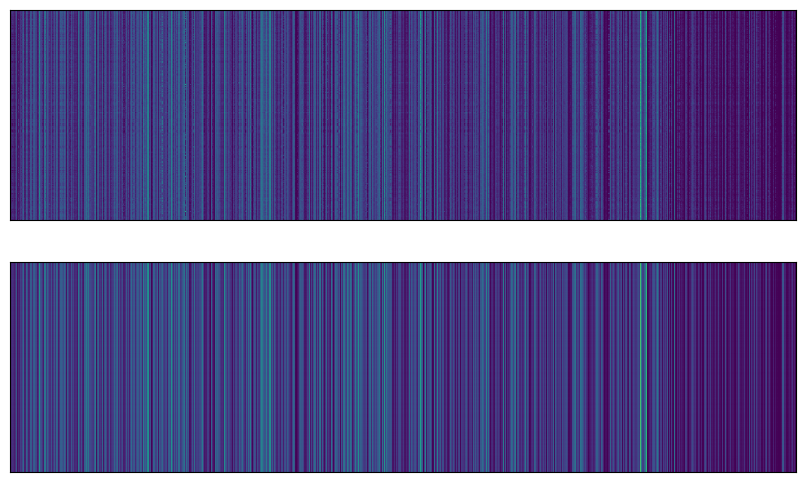

In [16]:
x = np.concatenate([x_test, x])
x_pred = model.predict(x)

fig, ax = plt.subplots(2, 1, figsize=(15, 6))

ax[0].imshow(x)
ax[1].imshow(x_pred)

for i in range(2):        
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
plt.show()

#### __6.1 Anomaly detection:__

In [17]:
mse = np.mean(pow(x-x_pred, 2), axis=1)

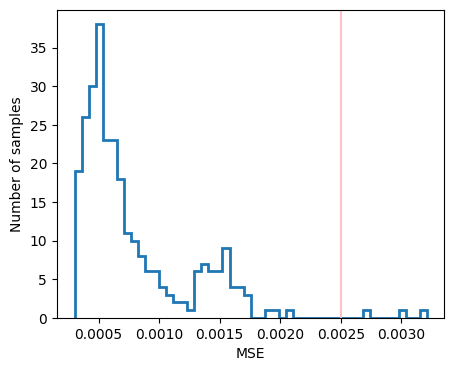

Outliers:
 [['113' 'Cg25' 'MDD' 'Male']
 ['63' 'OFC' 'MDD' 'Female']
 ['113' 'aINS' 'MDD' 'Male']]


In [18]:
threshold = 0.0025

plt.figure(figsize=(5,4))
plt.hist(mse, bins=50, histtype="step", lw=2)
plt.axvline(x=threshold, color='pink')
plt.xlabel("MSE")
plt.ylabel("Number of samples")
plt.show()

j = np.where(mse >= threshold)[0]

print("Outliers:\n", meta[j])

#### __6.2 Clustering__

### __7. Saving the model__:
<font size=3>
    
For model __loading__, see [2.2-notebook](2.2-notebook.ipynb).